## Run LOMs form ANL and LANL
Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

The purpose of this notebook is to read in inflow data and run the LOMs.

Output is saved into files named:

 > `anl|lanl_tid_windSource.csv.bz2`, where `windSource` is one of: `wtk`, `wtk_led_2018`, `wtk_led_2019`

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns

In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,LPC Link,Raster DEM Link,Site Type,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m)
0,t007,A2719,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),https://rockyweb.usgs.gov/vdelivery/Datasets/S...,NaN,Rural,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,NaN,NaN,NaN,NaN
1,t024,A2672,Washoe,Thomas Danzinger,NV,39.331088,-119.820234,30,QL1,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,Rural/Suburban,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN


### Select which sites need to be processed and wind data source

In [20]:
# Uncomment to process all:
#selected = tqdm(index["APRS ID"])

selected = ["t133", "t135"]

wind_source = "wtk_led_2018" # One of: ["wtk", "wtk_led_2018", "wtk_led_2019"]

### Load wind data

In [21]:
# Support 3 input sources

if wind_source == "wtk":
    
    wtk_df = pd.read_csv("01 Bergey Turbine Data/wtk.csv.bz2")

    # Create dict with dataframes that correspond to selected tid's
    atmospheric_inputs = {}
    for tid in selected:
        atmospheric_inputs[tid] = wtk_df[wtk_df["tid"] == tid].reset_index(drop=True)
        display(atmospheric_inputs[tid].head(3))
        
elif wind_source == "wtk_led_2018":
    
    wtk_led_2018 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2018.csv.bz2")

    # Create dict with dataframes that correspond to selected tid's
    atmospheric_inputs = {}
    for tid in selected:
        atmospheric_inputs[tid] = wtk_led_2018[wtk_led_2018["tid"] == tid].copy().reset_index(drop=True)
        atmospheric_inputs[tid]["datetime"] = atmospheric_inputs[tid]["packet_date"]
        display(atmospheric_inputs[tid].head(3))
    
elif wind_source == "wtk_led_2019":
    
    wtk_led_2019 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2019.csv.bz2")

    # Create dict with dataframes that correspond to selected tid's
    atmospheric_inputs = {}
    for tid in selected:
        atmospheric_inputs[tid] = wtk_led_2019[wtk_led_2019["tid"] == tid].copy().reset_index(drop=True)
        atmospheric_inputs[tid]["datetime"] = atmospheric_inputs[tid]["packet_date"]
        display(atmospheric_inputs[tid].head(3))
    
else:
    print("Unsupported wind_source selected.")

,tid,packet_date,ws,wd,datetime
0,t133,2018-01-01 00:00:00+00:00,7.898570,332.530536,2018-01-01 00:00:00+00:00
1,t133,2018-01-01 00:05:00+00:00,8.045085,331.155231,2018-01-01 00:05:00+00:00
2,t133,2018-01-01 00:10:00+00:00,8.207616,330.357975,2018-01-01 00:10:00+00:00


,tid,packet_date,ws,wd,datetime
0,t135,2018-01-01 00:00:00+00:00,3.612590,102.729230,2018-01-01 00:00:00+00:00
1,t135,2018-01-01 00:05:00+00:00,3.554217,105.278770,2018-01-01 00:05:00+00:00
2,t135,2018-01-01 00:10:00+00:00,3.498736,107.335028,2018-01-01 00:10:00+00:00


### Load obstacle data

100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.78it/s]


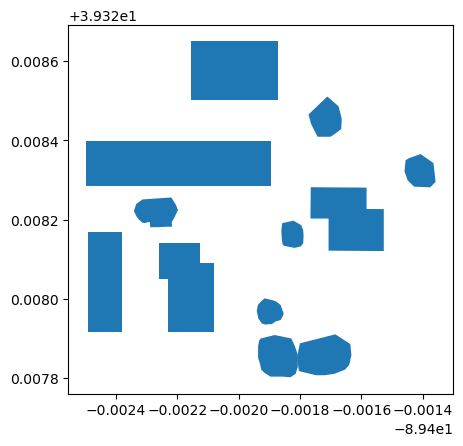

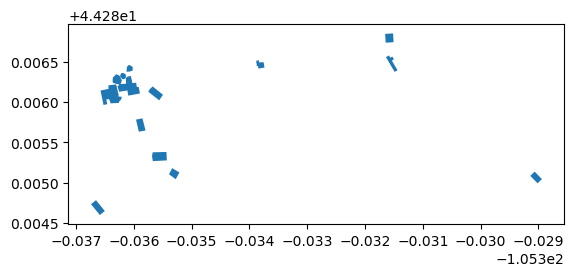

In [22]:
def filter_obstacles(obstacle_df):
    selected = obstacle_df[obstacle_df["height_median"] > 1.0].copy().reset_index(drop=True)
    selected["height"] = selected["height_median"]
    return selected[["height", "geometry"]]

obstacle_inputs = {}
for tid in tqdm(selected):
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file))
        obstacle_inputs[tid] = obstacle_df
        #display(obstacle_inputs[tid])
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    
# Quick vis:
for tid, obstacle_df in obstacle_inputs.items():
    obstacle_df.plot()

### Run ANL's LOM

In [23]:
dest_dir = "03 Model Outputs"
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

for tid in tqdm(selected):
    row = index[index["APRS ID"] == tid].iloc[0]
    #print(row)
    lat = row["Latitude"]
    lon = row["Longitude"]
    z_turbine = row["Hub Height (m)"]
    xy_turbine = [np.array([lon, lat])]
    
    predictions_df = run_lom(atmospheric_inputs[tid], obstacle_inputs[tid], \
                             xy_turbine, z_turbine, \
                             check_distance=True)
    
    # Add LOM output back to the more complete input dataframe
    atmospheric_inputs[tid]["ws-adjusted"] = predictions_df["ws-adjusted"]   
    atmospheric_inputs[tid].to_csv("%s/anl_%s_%s.csv.bz2" % (dest_dir, tid, wind_source), index=False)

100%|███████████████████████████████████████████████████████████████████████| 2/2 [03:18<00:00, 99.19s/it]


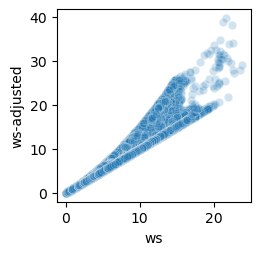

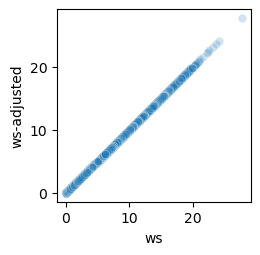

In [24]:
# Quick vis 
for tid in selected:
    fig = plt.gcf()
    fig.set_size_inches(2.5,2.5)
    sns.scatterplot(x=atmospheric_inputs[tid]["ws"], y=atmospheric_inputs[tid]["ws-adjusted"], alpha=0.2);
    plt.show()